In [3]:
import os
import re
import numpy as np
import numpy
genecode_genes = set(os.listdir("experiment_blood"))
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
import random
import bisect
import math
import json
import sys
from __future__ import print_function

In [4]:
def in_ipynb():
    try:
        get_ipython()
        return True
    except NameError:
        return False

In [5]:
if in_ipynb():
    from matplotlib import pyplot as plt

In [6]:
# Should be at least 10**4, preferably 10**6
r2_simulation_size = 10**6

In [7]:
print("Please use like this: `predictions.py <tissue> <genes> <simulation_runs> <top_k_genes> <PLSR_dimensions>`\n"\
      "tissue can be any of: blood, muscle.\n"\
      "genes can be any of: TNNI1, batra, nakamori, all\n"\
      "simulation runs can be 10\n"\
      "top_k_genes can be 500\n"\
      "PLSR_dimensions can be 2"
     )
if not in_ipynb():
    tissue_arg = sys.argv[1]
    print("tissue: {}".format(tissue_arg))
    gene_arg = sys.argv[2]
    print("gene: {}".format(gene_arg))
    simulation_arg = int(sys.argv[3])
    print("simulation_arg: {}".format(simulation_arg))
    top_genes_arg = int(sys.argv[4])
    print("top_genes_arg: {}".format(top_genes_arg))
    PLSR_arg = int(sys.argv[5])
    print("PLSR_arg: {}".format(PLSR_arg))

Please use like this: `predictions.py <tissue> <genes> <simulation_runs> <top_k_genes> <PLSR_dimensions>`
tissue can be any of: blood, muscle.
genes can be any of: TNNI1, batra, nakamori, all
simulation runs can be 10
top_k_genes can be 500
PLSR_dimensions can be 2


In [8]:
def load_genes(filename):
    genes = set()
    repeated = set()
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if line in genes:
                repeated.add(line)
            genes.add(line)
    failed = genes.difference(genecode_genes)
    if repeated:
        print("These genes appear more than once: {}".format([g for g in repeated]))
    if failed:
        print("Couldn't identify the following genes: {}".format([g for g in failed]))
    return genes.intersection(genecode_genes)

In [9]:
nakamori_genes = load_genes("nakamori_genes.txt")

These genes appear more than once: ['DMD', 'LDB3']
Couldn't identify the following genes: ['OPA', 'OHKA1']


In [10]:
len(nakamori_genes)

37

In [11]:
for gene in nakamori_genes:
    print(gene, end=" ")

CAPN3 DMD ALPK3 CLCN1 VPS39 TBC1D15 DTNA NFIX USP25 MBNL2 ATP2A1 INSR KIF13A GFPT1 BIN1 IMPDH2 LDB3 ABLIM2 ATP2A2 VEGFA CAMK2B ARFGAP2 RYR1 PDLIM3 TXNL4A CACNA1S FHOD1 SOS1 NRAP TTN UBE2D3 ANK2 CAPZB PHKA1 COPZ2 MLF1 MBNL1 

In [12]:
# Genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4224598/
batra_genes = load_genes("batra_genes.txt")

These genes appear more than once: ['TNNI1', 'CEBPA', 'IDH3A', 'SNX1', 'TPM2', 'LDB3', 'PCM1', 'NDUFB10', 'DNAJB6', 'PDLIM5', 'MEF2B', 'ASPH', 'TPM3', 'TTYH3', 'MST150', 'CHRNA1', 'TPM1']
Couldn't identify the following genes: ['DNAPTP6', 'CUGBP1', 'SR140', 'ADFP', 'MST150']


In [13]:
len(batra_genes)

75

In [14]:
for batra_gene in batra_genes:
    print(batra_gene, end=" ")

SPTB MDN1 AP1G1 GPS1 TNNI1 KRBA1 LAMP2 SLC25A36 CDC42 PCM1 NDUFB10 DES DNAJB6 MEF2D SPEG ASPH RIN1 ILF3 KDELR1 PFKFB2 DST BRSK2 CACNA1G MEF2C ATP5E CEBPA SETD3 TPM2 PDLIM2 ALG3 MBNL2 KCNK7 SAMD4A RAB24 MEF2B TPM3 TTYH3 DVL3 MGP MORC3 KIF1B AGL TBL2 AMHR2 TGFBI TMEM38B NR2F1 CLDND1 HDAC11 LDB3 COPS4 NUP43 DAPK2 CACNB1 PCMT1 PIK3C2B CHRNA1 MYH6 LMNA OSBPL1A PCBD2 IDH3A SNX1 TJP2 EZR PDLIM5 CIRBP FASTK MTCH1 RTN2 BRWD1 ABCA1 ARHGEF7 PEBP4 TPM1 

In [15]:
class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

In [16]:
blood_meta, muscle_meta = load_metadata()

In [17]:
def produce_data(meta, gene_names, experiment):
    IDs = meta.IDs
    probe_data = []
    probe_IDs = []
    for gene in gene_names:
        with open(os.path.join(experiment, gene)) as f:
            for i, line in enumerate(f):
                line = line.rstrip().split()
                if i == 0:
                    prefix = "patient_"
                    our_IDs = [elem[len(prefix):] for elem in line if re.match(prefix, elem)]
                    assert IDs == our_IDs
                    headers = {header: i for i, header in enumerate(line)}
                    patient_data = {header[len(prefix):]: i for i, header in enumerate(line) if re.match(prefix, header)}
                    def write_signature(line):
                        signature = []
                        for elem in ["gene_name", "probeset_id", "seq5to3plus", "chrom", "strand", "genocode_left", "genecode_right"]:
                            signature.append(line[headers[elem]])
                        return "_".join(signature)
                else:
                    probe_ID = write_signature(line)
                    rv = []
                    for patient_id in IDs:
                        rv.append(float(line[patient_data[patient_id]]))
                    probe_data.append(rv)
                    probe_IDs.append(probe_ID)
    probe_data = numpy.array(probe_data)
    return probe_data, probe_IDs

In [18]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[just_indices, :]

def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[0]):
        gene_r, _ = pearsonr(allele, data[i])
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[1]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[:, training_indices], data[:, test_indices]

def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

In [19]:
def filter_extremes(value, lowermost, uppermost):
    """If a value is lower or higher than lowermost or uppermost, return lowermost or uppermost. Otherwise, return value.
    """
    if value < lowermost:
        return lowermost
    if value > uppermost:
        return uppermost
    return value

In [20]:
def simulation_step(probeset_data, metadata, training_size, no_probes, n_components):
    """Execute a full step of the simulation, and return a tuple consisting of two lists:
    predicted repeat lengths, and the ground truth repeat lengths
    """
    training_i, testing_i = choose_training_indicies(probeset_data, training_size)
    training_fold, testing_fold = split_data(probeset_data, training_i, testing_i)
    repeat_length_training = [metadata.modal_allele[i] for i in training_i]
    repeat_length_testing = [metadata.modal_allele[i] for i in testing_i]
    
    top_genes = order_indicies(repeat_length_training, training_fold)[:no_probes]
    training_set = choose_top_genes(top_genes, training_fold)
    testing_set = choose_top_genes(top_genes, testing_fold)

    plsr = PLSRegression(n_components=n_components)
    
    plsr.fit(training_set.transpose(), cv(repeat_length_training))
    
    results = plsr.predict(testing_set.transpose())
    results = [filter_extremes(i[0], min(repeat_length_training), max(repeat_length_training)) for i in results]

    return repeat_length_testing, results

In [21]:
assert filter_extremes(0, 10, 20) == 10
assert filter_extremes(15, 10, 20) == 15
assert filter_extremes(25, 10, 20) == 20

In [22]:
metadata = {"muscle": muscle_meta, "blood": blood_meta}

In [23]:
data = {"muscle": {}, "blood": {}}
annot = {"muscle": {}, "blood": {}}

In [24]:
def load_data(name, genes, muscle_or_blood):
    meta = metadata[muscle_or_blood]
    path = "experiment_" + muscle_or_blood
    d, a = produce_data(meta, genes, path)
    data[muscle_or_blood][name] = d
    annot[muscle_or_blood][name] = a

In [25]:
gene_sets = {"nakamori": nakamori_genes, "batra": batra_genes, "TNNI1": ["TNNI1"], "all": genecode_genes}

In [26]:
for name, genes in gene_sets.items():
    for tissue in ["blood", "muscle"]:
        load_data(name, genes, tissue)

In [27]:
data

{'blood': {'TNNI1': array([[6.69115092, 6.4444247 , 6.64248078, ..., 6.80454457, 6.55574716,
          6.86989191],
         [6.30581892, 5.67237544, 6.09404785, ..., 6.23988077, 6.21940284,
          6.09071349],
         [6.24354023, 6.24884748, 6.2205972 , ..., 6.46642767, 6.51946868,
          6.23192685],
         ...,
         [4.82646635, 5.22487974, 5.36700186, ..., 5.45895102, 4.65676284,
          5.42493872],
         [5.31882519, 5.15013585, 5.09224063, ..., 4.90186895, 5.23235179,
          4.92086016],
         [4.50823911, 4.40335579, 4.79826011, ..., 4.10939995, 4.65729022,
          4.32519769]]),
  'all': array([[3.63486798, 3.6231591 , 3.70987072, ..., 3.73409837, 3.71761667,
          3.78107152],
         [5.01691034, 4.78684   , 5.20899118, ..., 5.3420667 , 4.80904565,
          4.97624542],
         [4.33864819, 4.92507272, 4.815622  , ..., 4.54285857, 4.60074592,
          5.07515576],
         ...,
         [4.77283865, 5.17042926, 4.46207894, ..., 4.96971219, 

In [28]:
def simulation(data, metadata, runs, no_probes, n_components):
    sample_no, patient_no = data.shape
    real_alleles = []
    simulated_alleles = []
    for i in range(runs):
        real_allele, simulated_allele = simulation_step(data, metadata, patient_no//2, no_probes, n_components)
        real_alleles += real_allele
        simulated_alleles += simulated_allele
    return real_alleles, simulated_alleles

In [29]:
def obtain_simulation(simulation, *args, **kwargs):
    real_alleles, simulated_alleles = simulation(*args, **kwargs)
    def save_at(path):
        with open(path, "w") as f:
            json.dump({"real_alleles": real_alleles,
                       "predicted_alleles": simulated_alleles,
                      }, f)
    return save_at

In [30]:
def analyse_simulation(path, r2_to_p):
    with open(path, "r") as f:
        result = json.load(f)
    real_alleles = result["real_alleles"]
    simulated_alleles = result["predicted_alleles"]
    r, _ = pearsonr(real_alleles, simulated_alleles)
    r_squared = r**2
    p_value = r2_to_p(r_squared)
    return real_alleles, simulated_alleles, r_squared, p_value, 

In [31]:
def present_result(name, tissue, real_allele, simulated_allele, r_squared, p_value):
    if in_ipynb():
        plt.figure()
        plt.scatter(real_allele, simulated_allele)
        plt.xlabel("measured allele length")
        plt.ylabel("predicted allele length")
    print("In {}, {} r² is {}, which corrsponds to p-value {}".format(name, tissue, r_squared, p_value))

In [32]:
def simulated_r2(metadata, times):
    r2s = []
    for i in range(times):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    def check_value(r_squared):
        p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(times)
        return p_value
    return check_value

In [33]:
muscle_r2_to_p = simulated_r2(muscle_meta, r2_simulation_size)

In [34]:
blood_r2_to_p = simulated_r2(blood_meta, r2_simulation_size)

In [35]:
r2_to_p = {"muscle": muscle_r2_to_p, "blood": blood_r2_to_p}

In [36]:
base_path = "simulation_results"
try:
    os.mkdir(base_path)
except OSError:
    pass

In [37]:
def example_workflow(name, tissue, simulation_runs, select_top_k_genes, PLSR_dimensions):
    path = os.path.join(base_path, "{}_{}_{}_{}_{}".format(name, tissue, simulation_runs, select_top_k_genes, PLSR_dimensions))
    obtain_simulation(simulation, data[tissue][name], metadata[tissue], simulation_runs, select_top_k_genes, PLSR_dimensions)(path)
    real_allele, simulated_allele, r2, p = analyse_simulation(path, r2_to_p[tissue])
    present_result(name, tissue, real_allele, simulated_allele, r2, p)

In nakamori, muscle r² is 0.1793197075787561, which corrsponds to p-value 0.02852100000000002
took 14.364564418792725 seconds


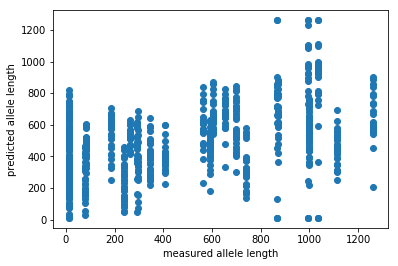

In [38]:
import time
start = time.time()
if not in_ipynb():
    example_workflow(name=gene_arg, tissue=tissue_arg, simulation_runs=simulation_arg, select_top_k_genes=top_genes_arg, PLSR_dimensions=PLSR_arg)
else:
    example_workflow(name="nakamori", tissue="muscle", simulation_runs=50, select_top_k_genes=500, PLSR_dimensions=2)
stop = time.time()
print("took {} seconds".format(stop - start))